# Using FISSA with CNMF from MATLAB

CNMF is blind source separation toolbox for cell detection and signal extraction. 

Here we illustrate how one can use the ROIs detected by CNMF, and use FISSA to extract and decontaminate the traces.

In this tutorial, we assume the user is using the [MATLAB implementation of CNMF](https://github.com/flatironinstitute/CaImAn-MATLAB). As such, this also serves as a tutorial on how to import data from MATLAB into Python to use with FISSA.

However, note that there is also a [Python implementation of CNMF](https://github.com/flatironinstitute/CaImAn), which you can use instead to keep your whole workflow in Python.

**Reference:**
> Pnevmatikakis, E.A., Soudry, D., Gao, Y., Machado, T., Merel, J., ... and Paninski, L. Simultaneous denoising, deconvolution, and demixing of calcium imaging data. *Neuron*, **89**(2):285-299, 2016. doi:&nbsp;[10.1016/j.neuron.2015.11.037](http://dx.doi.org/10.1016/j.neuron.2015.11.037).

### Import packages

In [1]:
# FISSA package
import fissa

# For plotting our results, import numpy and matplotlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Need this utility from scipy to load data from matfiles
from scipy.io import loadmat

## Running CNMF in MATLAB, and importing into Python

We ran CNMF in MATLAB using the [`run_pipeline.m`](https://github.com/flatironinstitute/CaImAn-MATLAB/blob/master/run_pipeline.m) script available from the CNMF repository on our example data (found at [../exampleData/20150529/](https://github.com/rochefort-lab/fissa/tree/master/examples/exampleData)).

We [saved](https://mathworks.com/help/matlab/ref/save.html) the `Coor` and `F_df` variables generated by that script into a `.mat` file ([cNMFdata.mat](https://github.com/rochefort-lab/fissa/blob/master/examples/cNMFdata.mat?raw=true)) which we now load here.

In [3]:
# Load data from cNMFdata.mat file
cNMFdata = loadmat("cNMFdata")["dat"]

# Get the F_df recording traces out of the loaded object
F_df = cNMFdata["F_df"][0, 0]

# Get the ROI outlines out of the loaded object
Coor = cNMFdata["Coor"][0, 0]

### Show detected cells

Let's render the ROIs using matplotlib.

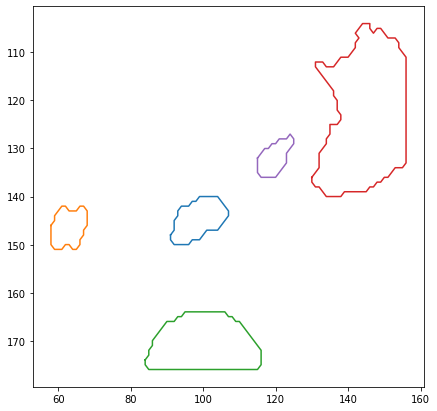

In [4]:
# Plotting lines surrounding each of the ROIs
plt.figure(figsize=(7, 7))

for i_cell in range(len(Coor)):
    x = Coor[i_cell, 0][0]
    y = Coor[i_cell, 0][1]
    # Plot border around cells
    plt.plot(x, y)

# Invert the y-axis because image co-ordinates are labelled from top-left
plt.gca().invert_yaxis()
plt.show()

## Running FISSA on cells detected by CNMF

FISSA needs ROIs to be provided either as an ImageJ zip file, or a set of numpy arrays.

CNMF can output ROIs in coordinates (as we imported above), which can be directly read into FISSA.
A given ROI after importing from MATLAB is given as

```python
Coor[i, 0]
```

FISSA expects a set of rois to be given as a list of lists,
```python
[[roiA1, roiA2, roiA3, ...]]
```
so we will need to change the format of the ROIs first.

In [5]:
numROI = len(Coor)
rois_FISSA = [[Coor[i, 0][0], Coor[i, 0][1]] for i in range(numROI)]

Which can then be put into FISSA and run as follows.

In [6]:
output_folder = "fissa_cnmf_example"
tiff_folder = "exampleData/20150529/"

experiment = fissa.Experiment(tiff_folder, [rois_FISSA], output_folder)
experiment.separate(redo_prep=True)

Extracting traces:   0%|          | 0/3 [00:00<?, ?it/s]

Finished extracting raw signals from 5 ROIs across 3 trials in 0.739 seconds.
Saving extracted traces to fissa_cnmf_example/prepared.npz


Separating data:   0%|          | 0/5 [00:00<?, ?it/s]

Finished separating signals from 5 ROIs across 3 trials in 1.652 seconds
Saving results to fissa_cnmf_example/separated.npz


## Plotting the results

Let's plot the traces for ROIs as they were detected by CNMF, and after removing neuropile with FISSA.

In [7]:
# Fetch the colormap object for Cynthia Brewer's Paired color scheme
cmap = plt.get_cmap("Paired")

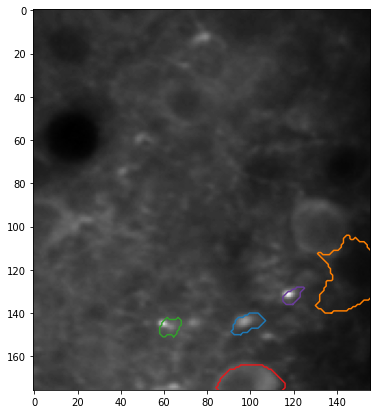

In [8]:
# Select which trial (TIFF index) to plot
trial = 0

# Plot the mean image and ROIs from the FISSA experiment
plt.figure(figsize=(7, 7))
plt.imshow(experiment.means[trial], cmap="gray")

XLIM = plt.xlim()
YLIM = plt.ylim()

for i_roi in range(len(experiment.roi_polys)):
    # Plot border around ROI
    for contour in experiment.roi_polys[i_roi, trial][0]:
        plt.plot(
            contour[:, 1],
            contour[:, 0],
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )

# ROI co-ordinates are half a pixel outside the image,
# so we reset the axis limits
plt.xlim(XLIM)
plt.ylim(YLIM)
plt.show()

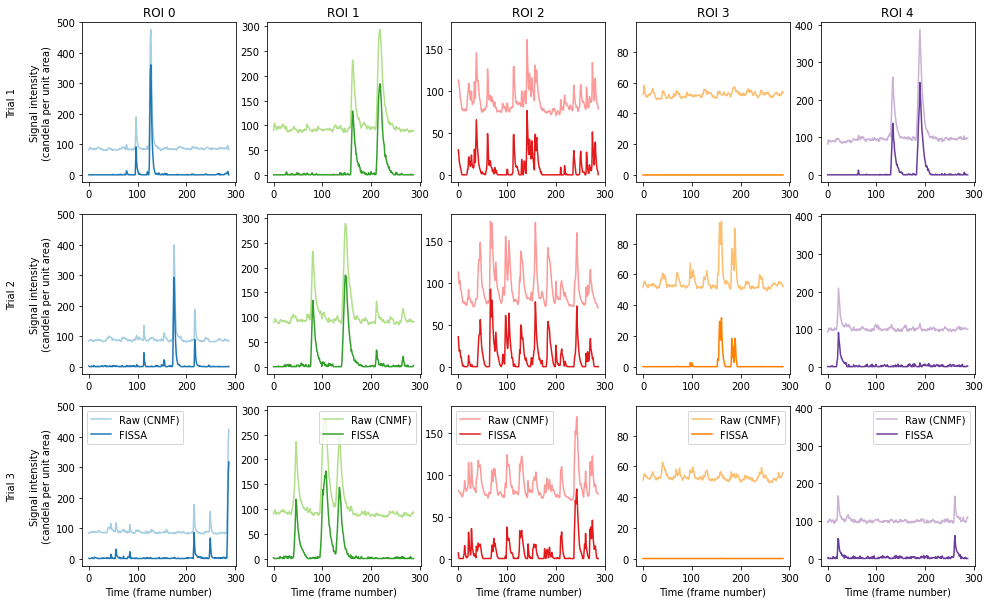

In [9]:
# Plot all ROIs and trials

# Get the number of ROIs and trials
n_roi = experiment.result.shape[0]
n_trial = experiment.result.shape[1]

# Find the maximum signal intensities for each ROI
roi_max_raw = [
    np.max([np.max(experiment.raw[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max_result = [
    np.max([np.max(experiment.result[i_roi, i_trial][0]) for i_trial in range(n_trial)])
    for i_roi in range(n_roi)
]
roi_max = np.maximum(roi_max_raw, roi_max_result)

# Plot our figure using subplot panels
plt.figure(figsize=(16, 10))
for i_roi in range(n_roi):
    for i_trial in range(n_trial):
        # Make subplot axes
        i_subplot = 1 + i_trial * n_roi + i_roi
        plt.subplot(n_trial, n_roi, i_subplot)
        # Plot the data
        plt.plot(
            experiment.raw[i_roi][i_trial][0, :],
            label="Raw (CNMF)",
            color=cmap((i_roi * 2) % cmap.N),
        )
        plt.plot(
            experiment.result[i_roi][i_trial][0, :],
            label="FISSA",
            color=cmap((i_roi * 2 + 1) % cmap.N),
        )
        # Labels and boiler plate
        plt.ylim([-0.05 * roi_max[i_roi], roi_max[i_roi] * 1.05])
        if i_roi == 0:
            plt.ylabel(
                "Trial {}\n\nSignal intensity\n(candela per unit area)".format(
                    i_trial + 1
                )
            )
        if i_trial == 0:
            plt.title("ROI {}".format(i_roi))
        if i_trial == n_trial - 1:
            plt.xlabel("Time (frame number)")
            plt.legend()

plt.show()

The figure shows the raw signal from the ROI identified by CNMF (pale), and after decontaminating with FISSA (dark).
The hues match the ROI locations drawn above.
Each column shows the results from one of the ROIs detected by CNMF.
Each row shows the results from one of the three trials.